In [2]:
import os
import torch
from torch_geometric.data import Data
from ase.io import read
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Paths and global settings
POSCAR_DIR = "/home/ah/Desktop/GNN/POSCAR"
CHARGE_DIR = "/home/ah/Desktop/GNN/CHARGE"
OUTPUT_DIR = "/home/ah/Desktop/GNN/Preprocessed_Data"
data_max_files = 500

# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Validate paths
print(f"POSCAR_DIR: {POSCAR_DIR}, Exists? {os.path.exists(POSCAR_DIR)}")
if os.path.exists(POSCAR_DIR):
    print(f"Sample files: {os.listdir(POSCAR_DIR)[:5]}")
print(f"CHARGE_DIR: {CHARGE_DIR}, Exists? {os.path.exists(CHARGE_DIR)}")
if os.path.exists(CHARGE_DIR):
    print(f"Sample files: {os.listdir(CHARGE_DIR)[:5]}")

# Expanded atomic properties
atomic_properties = {
    1: {"electronegativity": 2.20, "mass": 1.008, "valence": 1, "radius": 0.53},  # H
    3: {"electronegativity": 0.98, "mass": 6.941, "valence": 1, "radius": 1.52},  # Li
    6: {"electronegativity": 2.55, "mass": 12.011, "valence": 4, "radius": 0.67},  # C
    7: {"electronegativity": 3.04, "mass": 14.007, "valence": 5, "radius": 0.56},  # N
    8: {"electronegativity": 3.44, "mass": 15.999, "valence": 6, "radius": 0.48},  # O
    9: {"electronegativity": 3.98, "mass": 18.998, "valence": 7, "radius": 0.42},  # F
    11: {"electronegativity": 0.93, "mass": 22.990, "valence": 1, "radius": 1.90},  # Na
    14: {"electronegativity": 1.90, "mass": 28.085, "valence": 4, "radius": 1.11},  # Si
    15: {"electronegativity": 2.19, "mass": 30.974, "valence": 5, "radius": 0.98},  # P
    16: {"electronegativity": 2.58, "mass": 32.06, "valence": 6, "radius": 0.88},  # S
    17: {"electronegativity": 3.16, "mass": 35.45, "valence": 7, "radius": 0.79},  # Cl
    26: {"electronegativity": 1.83, "mass": 55.845, "valence": 2, "radius": 1.24},  # Fe
}

# Function to load and preprocess a single molecular graph
def preprocess_molecular_graph(poscar_path, charge_path):
    atoms = read(poscar_path, format='vasp')
    atomic_numbers = atoms.get_atomic_numbers()
    n_atoms = len(atoms)

    # Create node features
    x = torch.tensor([
        [
            atomic_numbers[i],
            atomic_properties.get(atomic_numbers[i], {"electronegativity": 0.0}).get("electronegativity", 0.0),
            atomic_properties.get(atomic_numbers[i], {"mass": 0.0}).get("mass", 0.0),
            atomic_properties.get(atomic_numbers[i], {"valence": 0.0}).get("valence", 0.0),
            atomic_properties.get(atomic_numbers[i], {"radius": 0.0}).get("radius", 0.0),
        ]
        for i in range(n_atoms)
    ], dtype=torch.float)

    # Compute pairwise distances with PBC
    distances = atoms.get_all_distances(mic=True)
    threshold = 5.0  # Increased threshold to ensure edges are created
    i, j = np.triu_indices(n_atoms, k=1)
    mask = distances[i, j] < threshold
    edge_pairs = np.stack([i[mask], j[mask]], axis=0)
    edge_distances = distances[i, j][mask]
    edge_index = np.concatenate([edge_pairs, edge_pairs[::-1]], axis=1)

    # Edge features
    edge_distances = np.concatenate([edge_distances, edge_distances])
    edge_attr_inv = 1.0 / (edge_distances + 1e-6)
    centers = np.linspace(0, threshold, 10)
    edge_attr_gauss = np.exp(-(edge_distances[:, None] - centers) ** 2 / 0.5)
    edge_attr = np.concatenate([edge_attr_inv[:, None], edge_attr_gauss], axis=1)
    edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Load charges
    with open(charge_path, 'r') as f:
        charges = [float(line.strip()) for line in f if line.strip()]
    charges = np.array(charges)

    if len(atoms) != len(charges):
        raise ValueError(f"Mismatch: {len(atoms)} atoms vs {len(charges)} charges in {poscar_path}")

    return x, edge_index, edge_attr, charges

# Function to preprocess the entire dataset
def preprocess_dataset(max_files):
    if not os.path.exists(POSCAR_DIR) or not os.path.exists(CHARGE_DIR):
        print("Directory not found!")
        return None, None, None

    poscar_files = sorted(os.listdir(POSCAR_DIR))[:min(max_files, len(os.listdir(POSCAR_DIR)))]
    all_charges = []
    valid_poscar_files = []
    preprocessed_data = []

    # Collect charges and validate files
    for poscar_file in poscar_files:
        try:
            number = poscar_file.split('_')[1].replace('.POSCAR', '')
            charge_path = os.path.join(CHARGE_DIR, f"CHARGE_{number}")
            if not os.path.exists(charge_path):
                print(f"Charge file not found for {poscar_file}. Skipping.")
                continue

            with open(charge_path, 'r') as f:
                charges = [float(line.strip()) for line in f if line.strip()]
            all_charges.extend(charges)
            valid_poscar_files.append(poscar_file)
        except Exception as e:
            print(f"Error processing {poscar_file}: {e}")
            continue

    if not all_charges:
        print("No valid charge data found. Exiting.")
        return None, None, None

    # Analyze charge distribution
    all_charges = np.array(all_charges)
    print(f"Global charge range: {np.min(all_charges):.4f} to {np.max(all_charges):.4f}")
    print(f"Mean charge: {np.mean(all_charges):.4f}, Std: {np.std(all_charges):.4f}")

    # Plot charge distribution
    plt.figure(figsize=(8, 6))
    plt.hist(all_charges, bins=50, density=True, alpha=0.7)
    plt.xlabel("Charge")
    plt.ylabel("Density")
    plt.title("Distribution of Atomic Charges")
    plt.savefig(os.path.join(OUTPUT_DIR, "charge_distribution.png"))
    plt.close()

    # Apply log-transform if needed
    charge_min, charge_max = np.min(all_charges), np.max(all_charges)
    if charge_min < 0:
        shifted_charges = all_charges - charge_min + 1e-6
    else:
        shifted_charges = all_charges + 1e-6
    log_charges = np.log(shifted_charges)
    skewness = (np.mean(log_charges) - np.median(log_charges)) / np.std(log_charges)
    print(f"Skewness of log-transformed charges: {skewness:.4f}")

    use_log_transform = abs(skewness) < 0.5
    if use_log_transform:
        print("Applying log-transform to charges.")
        charges_to_normalize = log_charges
        charge_min, charge_max = np.min(log_charges), np.max(log_charges)
        normalization_type = "log"
    else:
        print("Using standard normalization.")
        charges_to_normalize = all_charges
        charge_min, charge_max = np.min(all_charges), np.max(all_charges)
        normalization_type = "standard"

    # Normalize to [0, 1]
    charges_to_normalize = (charges_to_normalize - charge_min) / (charge_max - charge_min)
    print(f"Normalized charge range (should be 0 to 1): {np.min(charges_to_normalize):.4f} to {np.max(charges_to_normalize):.4f}")

    # Preprocess each graph
    charge_idx = 0
    for poscar_file in valid_poscar_files:
        try:
            poscar_path = os.path.join(POSCAR_DIR, poscar_file)
            number = poscar_file.split('_')[1].replace('.POSCAR', '')
            charge_path = os.path.join(CHARGE_DIR, f"CHARGE_{number}")
            x, edge_index, edge_attr, charges = preprocess_molecular_graph(poscar_path, charge_path)

            # Normalize charges
            if use_log_transform:
                if np.min(charges) < 0:
                    charges = charges - np.min(charges) + 1e-6
                else:
                    charges = charges + 1e-6
                charges = np.log(charges)
            charges = (charges - charge_min) / (charge_max - charge_min)
            y = torch.tensor(charges, dtype=torch.float).unsqueeze(1)

            # Create Data object
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            preprocessed_data.append(data)
        except Exception as e:
            print(f"Error preprocessing {poscar_file}: {e}")
            continue

    # Save preprocessed data
    with open(os.path.join(OUTPUT_DIR, "preprocessed_dataset.pkl"), 'wb') as f:
        pickle.dump(preprocessed_data, f)
    with open(os.path.join(OUTPUT_DIR, "normalization_params.pkl"), 'wb') as f:
        pickle.dump({
            "charge_min": charge_min,
            "charge_max": charge_max,
            "normalization_type": normalization_type
        }, f)

    return preprocessed_data, charge_min, charge_max

# Main execution
def main():
    preprocessed_data, charge_min, charge_max = preprocess_dataset(max_files=data_max_files)
    if preprocessed_data is None or len(preprocessed_data) == 0:
        print("No data preprocessed. Exiting.")
        return

    print(f"Preprocessed {len(preprocessed_data)} graphs.")
    print(f"Charge normalization range: {charge_min:.4f} to {charge_max:.4f}")
    print(f"Sample graph: {preprocessed_data[0]}")

if __name__ == "__main__":
    main()

POSCAR_DIR: /home/ah/Desktop/GNN/POSCAR, Exists? True
Sample files: ['CONFIG_8277.POSCAR', 'CONFIG_6508.POSCAR', 'CONFIG_5076.POSCAR', 'CONFIG_14357.POSCAR', 'CONFIG_1256.POSCAR']
CHARGE_DIR: /home/ah/Desktop/GNN/CHARGE, Exists? True
Sample files: ['CHARGE_7143', 'CHARGE_11222', 'CHARGE_14548', 'CHARGE_17963', 'CHARGE_7997']
Global charge range: -1.5140 to 1.5658
Mean charge: 0.0000, Std: 1.2732
Skewness of log-transformed charges: -0.4766
Applying log-transform to charges.
Normalized charge range (should be 0 to 1): 0.0000 to 1.0000
Preprocessed 500 graphs.
Charge normalization range: -13.8155 to 1.1249
Sample graph: Data(x=[216, 5], edge_index=[2, 5616], edge_attr=[5616, 11], y=[216, 1])


Loaded 500 graphs.
Normalization params: {'charge_min': np.float64(-13.815510557964274), 'charge_max': np.float64(1.1248529706731392), 'normalization_type': 'log'}


/tmp/ipykernel_21322/859116011.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/home/ah/Desktop/GNN/env/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/tmp/ipykernel_21322/859116011.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/ah/Desktop/GNN/env/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/tmp/ipykernel_21322/859116011.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 1/100, Train Loss: 0.2545, Val Loss: 0.2266, LR: 0.001000, Memory: 41.2%
Epoch 2/100, Train Loss: 0.2278, Val Loss: 0.2261, LR: 0.001000, Memory: 41.0%
Epoch 3/100, Train Loss: 0.2229, Val Loss: 0.2264, LR: 0.001000, Memory: 38.9%
Epoch 4/100, Train Loss: 0.2226, Val Loss: 0.2267, LR: 0.001000, Memory: 38.2%
Epoch 5/100, Train Loss: 0.2215, Val Loss: 0.2271, LR: 0.001000, Memory: 37.5%
Epoch 6/100, Train Loss: 0.2212, Val Loss: 0.2224, LR: 0.001000, Memory: 36.9%
Epoch 7/100, Train Loss: 0.2201, Val Loss: 0.2231, LR: 0.001000, Memory: 37.8%
Epoch 8/100, Train Loss: 0.2191, Val Loss: 0.2205, LR: 0.001000, Memory: 38.6%
Epoch 9/100, Train Loss: 0.2172, Val Loss: 0.2188, LR: 0.001000, Memory: 37.4%
Epoch 10/100, Train Loss: 0.2142, Val Loss: 0.2097, LR: 0.001000, Memory: 37.6%
Epoch 11/100, Train Loss: 0.2111, Val Loss: 0.2076, LR: 0.001000, Memory: 37.6%
Epoch 12/100, Train Loss: 0.2058, Val Loss: 0.1947, LR: 0.001000, Memory: 37.1%
Epoch 13/100, Train Loss: 0.1998, Val Loss: 0.183

/tmp/ipykernel_21322/859116011.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Test Loss (MSE): 0.0112
  MSE: 0.0112, RMSE: 0.1058, MAE: 0.0488, R²: 0.9455


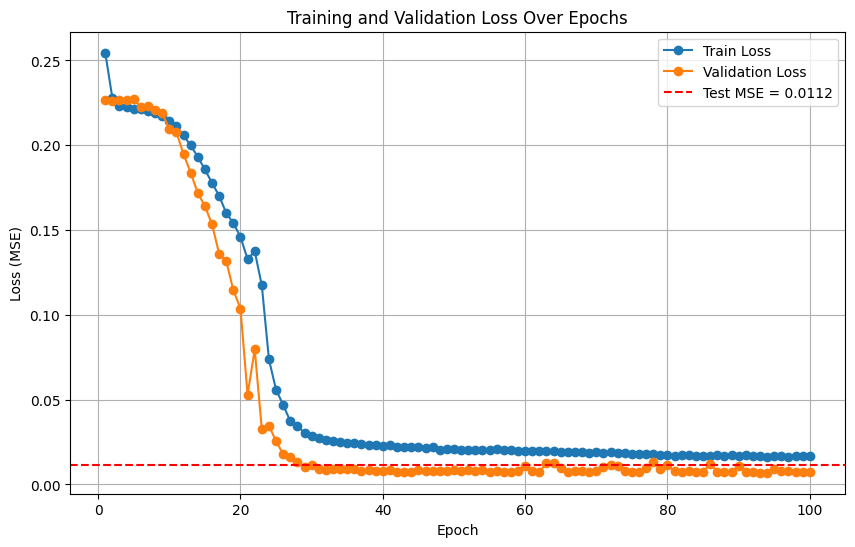

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import psutil
from torch.cuda.amp import GradScaler, autocast

# Paths and global settings
PREPROCESSED_DATA_PATH = "/home/ah/Desktop/GNN/Preprocessed_Data/preprocessed_dataset.pkl"
NORMALIZATION_PARAMS_PATH = "/home/ah/Desktop/GNN/Preprocessed_Data/normalization_params.pkl"
MODEL_SAVE_PATH = "/home/ah/Desktop/GNN/gnn_atomic_charge_model.pth"
number_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load preprocessed data
with open(PREPROCESSED_DATA_PATH, 'rb') as f:
    dataset = pickle.load(f)
with open(NORMALIZATION_PARAMS_PATH, 'rb') as f:
    normalization_params = pickle.load(f)

print(f"Loaded {len(dataset)} graphs.")
print(f"Normalization params: {normalization_params}")

# GNN Model (simplified to avoid overfitting)
class GNNModel(torch.nn.Module):
    def __init__(self, input_dim=5, edge_dim=11, hidden_dim=128, output_dim=1, heads=4):
        super(GNNModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.3, edge_dim=edge_dim)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, dropout=0.3, edge_dim=edge_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.sigmoid = torch.nn.Sigmoid()  # Output in [0, 1]
    
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.fc(x)
        return self.sigmoid(x)

# Training function
def train_model(model, train_loader, val_loader, epochs, lr, accum_steps=4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    criterion = torch.nn.MSELoss()
    scaler = GradScaler()
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience, patience_counter = 20, 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        optimizer.zero_grad()
        for i, batch in enumerate(train_loader):
            batch = batch.to(device)
            with autocast():
                out = model(batch)
                loss = criterion(out, batch.y) / accum_steps
            scaler.scale(loss).backward()
            train_loss += loss.item() * accum_steps
            if (i + 1) % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            del batch, out, loss
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad(), autocast():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch)
                val_loss += criterion(out, batch.y).item()
                del batch, out
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

        scheduler.step(val_loss)
        mem_usage = psutil.virtual_memory().percent
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}, Memory: {mem_usage:.1f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH.replace(".pth", "_best.pth"))
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, val_losses

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    test_loss, total_mae, ss_tot, ss_res, n_samples, mean_targets = 0, 0, 0, 0, 0, 0
    criterion = torch.nn.MSELoss()

    with torch.no_grad(), autocast():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y)
            test_loss += loss.item()
            preds = out.cpu().detach()
            targets = batch.y.cpu().detach()
            n_batch = targets.size(0)
            n_samples += n_batch
            total_mae += torch.sum(torch.abs(preds - targets)).item()
            mean_targets = (mean_targets * (n_samples - n_batch) + torch.sum(targets).item()) / n_samples
            ss_tot += torch.sum((targets - mean_targets) ** 2).item()
            ss_res += torch.sum((targets - preds) ** 2).item()
            del batch, out, loss, preds, targets
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
        test_loss /= len(test_loader)

    mse = test_loss
    rmse = torch.sqrt(torch.tensor(mse)).item()
    mae = total_mae / n_samples
    r2 = 1 - (ss_res / ss_tot)

    return test_loss, mse, rmse, mae, r2

# Main execution
def main():
    # Split dataset
    indices = list(range(len(dataset)))
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)

    train_loader = DataLoader(dataset, batch_size=16, sampler=torch.utils.data.SubsetRandomSampler(train_idx), num_workers=0)
    val_loader = DataLoader(dataset, batch_size=16, sampler=torch.utils.data.SubsetRandomSampler(val_idx), num_workers=0)
    test_loader = DataLoader(dataset, batch_size=16, sampler=torch.utils.data.SubsetRandomSampler(test_idx), num_workers=0)

    # Initialize model
    model = GNNModel(input_dim=5, edge_dim=11, hidden_dim=128, output_dim=1, heads=4).to(device)

    # Train model
    train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=number_epochs, lr=0.001)

    # Load best model and evaluate
    model.load_state_dict(torch.load(MODEL_SAVE_PATH.replace(".pth", "_best.pth")))
    test_loss, mse, rmse, mae, r2 = evaluate_model(model, test_loader)

    print(f"Test Loss (MSE): {test_loss:.4f}")
    print(f"  MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    torch.save(model.state_dict(), MODEL_SAVE_PATH)

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o')
    plt.axhline(y=mse, color='r', linestyle='--', label=f"Test MSE = {mse:.4f}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.savefig("/home/ah/Desktop/GNN/loss_plot.png")
    plt.show()

if __name__ == "__main__":
    main()